# Illustration of functions approximated by a Neural Network

In this notebook we try to build some intuition for the nature of neural networks as “universal function approximators”. We will explore how the input get warped by a multilayer perceptron that has been initialized with random weights. We restrict ourselves to input and output that can be easily plotted.

## Setup

In [1]:
# Setup some imports and basic plotting parameters

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torchsummary import summary


%matplotlib inline

plt.rcParams.update(
    { 'font.size': 14,
      'font.family': "sans-serif"
    }
)

In [160]:
# functions for setting up a vanilla neural network

def get_vanilla_neural_network(input_dim, output_dim, n_hidden_layers,
                               hidden_dims, activation='tanh'):
    """Create a vanilla neural network
    
    Parameters
    ----------
    input_dim: int
        The size of the input vector
        
    output_dim: int
        The size of the output vector
    
    n_hidden_layers: int
        The number of hidden layers in the perceptron
        
    hidden_dims: list of ints
        The number of nodes in each of the hidden layers
        
    activation: str
        Activation function. One of `tanh` or `relu`
        
    Returns
    -------
    model = torch.nn
        A pytorch neural network
    """
    if activation == 'tanh':
        activationfn = torch.nn.Tanh()
    elif activation == 'relu':
        activationfn = torch.nn.ReLU()
    else:
        raise NotImplementedError('Activation function not implemented')
        
    assert len(hidden_dims) == n_hidden_layers, (
            "length of hidden dimensions does not match number of hidden layers")
    
    layers = [torch.nn.Linear(input_dim, hidden_dims[0]),
              activationfn]
    
    for i in range(n_hidden_layers - 1):
        layers = layers + [torch.nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                activationfn]

    layers.append(torch.nn.Linear(hidden_dims[-1], output_dim))

    model = torch.nn.Sequential(*layers)
    
    return model

def init_weights(m):
    """Initialize the weights of a neural network
    
    This function initializes the parameters of the neural network from 
    a Normal distribution with 0 mean and 0.5 standard deviation. Both the
    weights and biases are initialized using this distribution.
    
    Parameters
    ----------
    m: torch.nn
        The neural network whose parameters are being initialized
    """
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, 0, 0.5)
        m.bias.data.normal_(0, 0.5)

def plot_activation(activation, ax=None):

    x = torch.linspace(-d, d, N)
    if activation == 'tanh':
        y = np.tanh(x)
    elif activation == 'relu':
        y = np.maximum(x, 0)
    else:
        raise NotImplementedError('Activation function not implemented')

    if ax == None:
      fig, ax = plt.subplots(figsize=(8.0,8.0))
    ax.plot(x,y)
    ax.set_title(activation)
    ax.set_ylim([-1, 1])

def plot_1D_warping(model, ax=None, n_runs=5):

    assert model[0].in_features == 1, 'input dimension must be one'
    assert model[-1].out_features == 1, 'output dimension must be one'

    x = torch.linspace(-1.0, 1.0, 400)
    y = x.clone()

    if ax == None:
      fig, ax = plt.subplots(figsize=(8.0,8.0))
      ax.plot(x,y, color='k', ls='--')
    colors = plt.cm.viridis(np.linspace(0,1,n_runs))

    afn = str(model[1])

    hidden_dims = []
    for idx in range(len(model) - 1):
      try:
        hidden_dims.append(model[idx].out_features)
      except:
        None
    ax.set_title(f'Activation function : {afn}\nNumber Of Layers: {int((len(model) - 1)/2)}\nHidden Dimensions: {hidden_dims}')
    for run in range(n_runs):
      model.apply(init_weights)
      y_new = []    
      for i in x:
        i = torch.Tensor([i])
        y_new.append(torch.squeeze(model(i)).detach().numpy())
    
      y_new = np.array(y_new).flatten()
      ax.plot(x,y_new, color=colors[run], lw=2, alpha=0.5)


def plot_2D_warping(model, ax=None, heatmap=False):

    assert model[0].in_features == 2, 'input dimension must be two'
    assert model[-1].out_features == 1, 'output dimension must be one'

    # set up grid
    d = 1.0
    N = 100
    x = torch.linspace(-d, d, N)
    y = torch.linspace(-d, d, N)
    xx = torch.matmul(torch.ones([N, 1]), x.reshape([1, N]))
    yy = torch.matmul(y.reshape([N, 1]), torch.ones([1, N]))
    xx = torch.reshape(xx, [-1])
    yy = torch.reshape(yy, [-1])

    z = []
    for x, y in zip(xx, yy):
      input = torch.Tensor([x, y])
      z.append(model(input).item())

    z = np.array(z).flatten()

    if ax == None:
      fig = plt.figure(figsize=(8.0,8.0))
      ax = fig.add_subplot(projection='3d')

    if heatmap == True:
      ax.tripcolor(xx, yy, z, cmap=plt.get_cmap('YlGnBu_r'))
    else:
      ax.tripcolor(xx, yy, z, cmap=plt.get_cmap('YlGnBu_r'))

    afn = str(model[1])

    hidden_dims = []
    for idx in range(len(model) - 1):
      try:
        hidden_dims.append(model[idx].out_features)
      except:
        None
    ax.set_title(f'Activation function : {afn}\nNumber Of Layers: {int((len(model) - 1)/2)}\nHidden Dimensions: {hidden_dims}')
    ax.set_axis_off()

## Activation Functions

Neural Networks approximate complex functions by stacked linear layers (with parameters) and nonlinear *activation functions* (typically without parameters). Below are graphs for two activation functions that are typically used: `tanh` and `relu` (**Re**ctified **L**inear **U**nit).

The function `relu` is popular for most vanilla NNs or Convolutional NNs. Here the word "activation" is suggestive. We see that a node with `relu` activation function "activates when the output of the linear layer is positive.

The `tanh` function is generally used when one wants to constrain the outputs in the interval (-1,1). Many Recurrent NN architectures make use of `tanh` activation functions

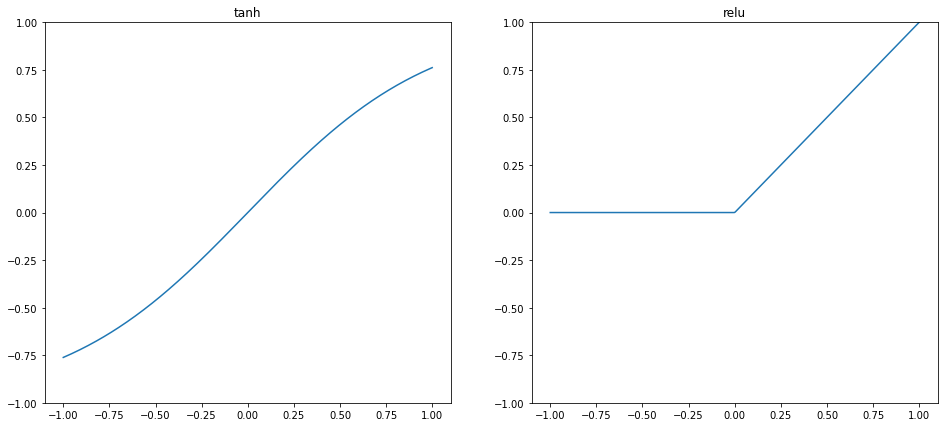

In [127]:
# Setup the plotting
fig = plt.figure(figsize=(16.0,7.0))
gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

plot_activation('tanh', ax=ax1)
plot_activation('relu', ax=ax2)


## 1D Example

The simplest case is creating a function with one-dimensional input and output, $f:\mathbb{R} \rightarrow \mathbb{R}$ (or in more familiar form $y = f(x)$). We will see how a fully connected neural network warps one-dimensional input. Let's consider a two-layer neural network (with the dimension of the first layer given by `hidden_dim`) for this example. 

![](https://drive.google.com/uc?id=1NalKv81wARV4SpQO35OB7sIfXKAuVKDd)

This visualization was generated using the tool for visualizing neural networks which can be found [here](http://alexlenail.me/NN-SVG/index.html).

In [155]:
input_dim = 1
output_dim = 1
n_layers = 1
hidden_dim = 10

model = get_vanilla_neural_network(input_dim, output_dim, n_layers,
                                   [hidden_dim], activation='tanh')

# outputs the dimension of the input as it goes through the net
# the negative one is a placeholder for the batch size
summary(model, input_size = (1,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              20
              Tanh-2                   [-1, 10]               0
            Linear-3                    [-1, 1]              11
Total params: 31
Trainable params: 31
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Now let's graph the output.

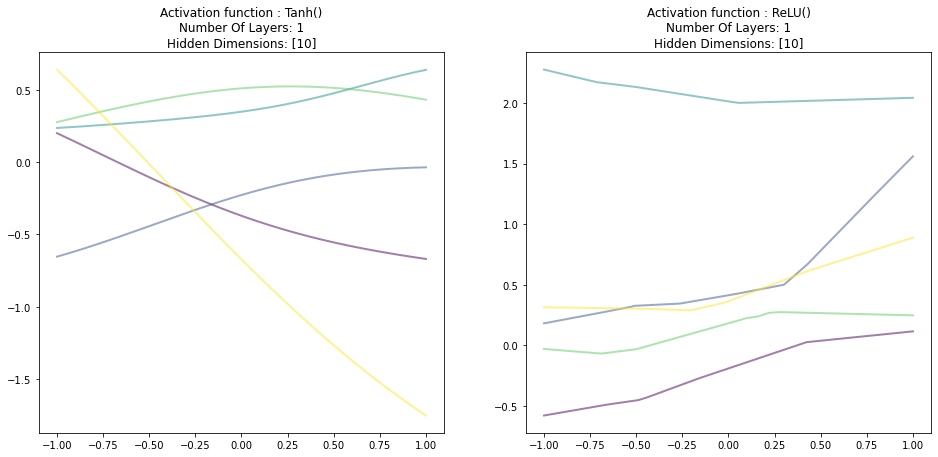

In [156]:
model_relu = get_vanilla_neural_network(input_dim, output_dim, n_layers,
                                   [hidden_dim], activation='relu')

fig = plt.figure(figsize=(16.0,7.0))
gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

plot_1D_warping(model, ax=ax1)
plot_1D_warping(model_relu, ax=ax2)

Check out how adding more layers or changing the nodes per layer heaps on more twisting and distorting.  

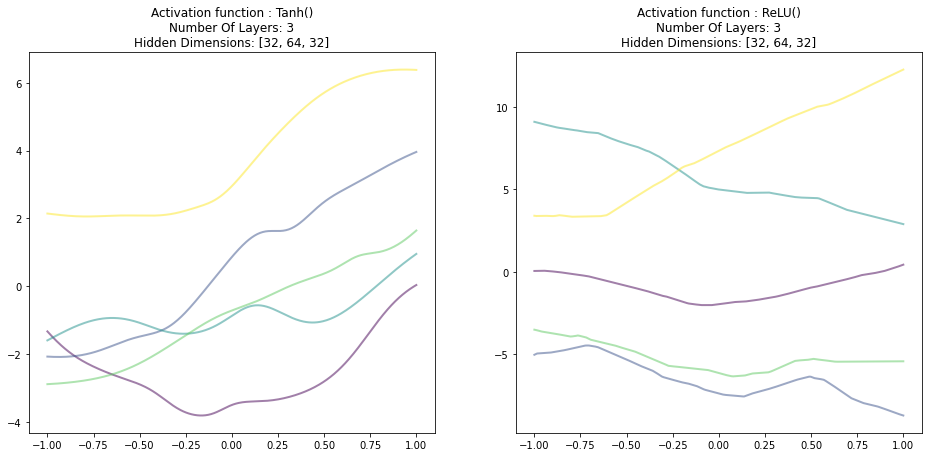

In [157]:
input_dim = 1
output_dim = 1
n_layers = 3
hidden_dims = [32, 64, 32]

model1 = get_vanilla_neural_network(input_dim, output_dim, n_layers,
                                   hidden_dims, activation='tanh')
model2 = get_vanilla_neural_network(input_dim, output_dim, n_layers,
                                   hidden_dims, activation='relu')

fig = plt.figure(figsize=(16.0,7.0))
gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

plot_1D_warping(model1, ax=ax1)
plot_1D_warping(model2, ax=ax2)

## 2D Example

The best we can do with our 3D-constrained perception is visualize a neural network of the form $f:\mathbb{R}^2 \rightarrow\mathbb{R}$, a function which warps the 2D plane. In the following we create two 4-layer neural networks with random weights and different activation functions.

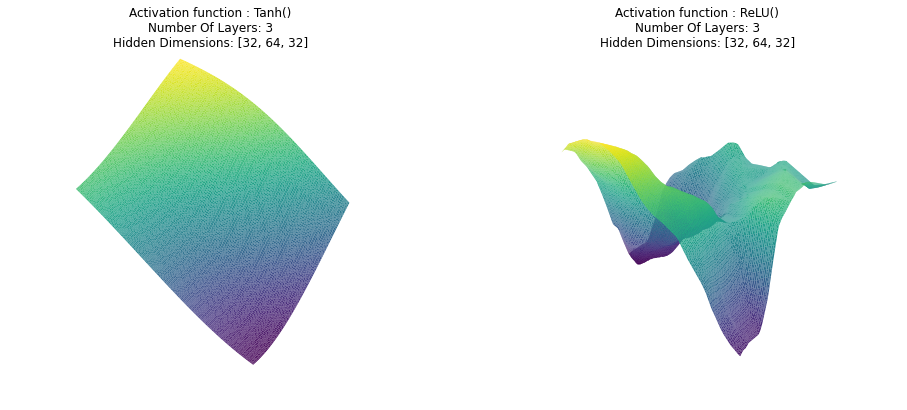

In [159]:
model1 = get_vanilla_neural_network(2, 1, 3,
                                   [32, 64, 32], activation='tanh')

model2 = get_vanilla_neural_network(2, 1, 3,
                                   [32, 64, 32], activation='relu')


fig = plt.figure(figsize=(16.0,7.0))
gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0,0], projection='3d')
ax2 = fig.add_subplot(gs[0,1], projection='3d')

plot_2D_warping(model1, ax=ax1)
plot_2D_warping(model2, ax=ax2)

Here are the corresponding heatmaps.

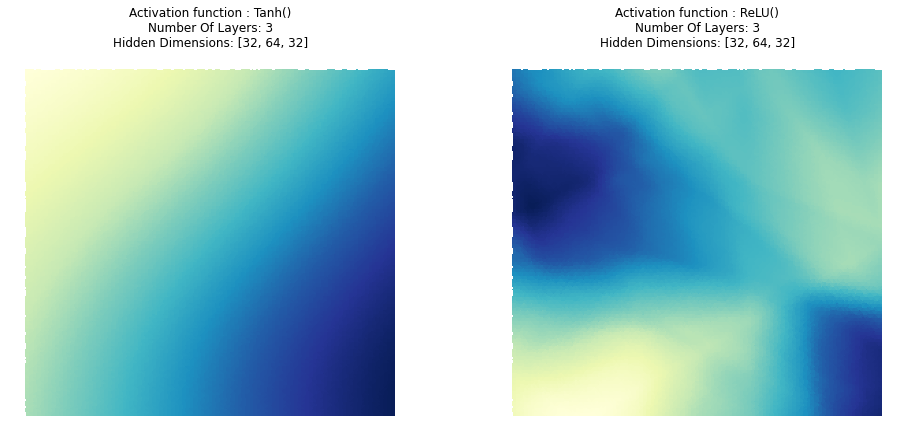

In [162]:
fig = plt.figure(figsize=(16.0,7.0))
gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

plot_2D_warping(model1, ax=ax1, heatmap=True)
plot_2D_warping(model2, ax=ax2, heatmap=True)